## Project 3 - Decision Tree

Team members: Sai Hari Charan, Shravya Pentaparthi, Hemant Koti <br>

Decision tree algorithm implementation.

In [130]:
# from google.colab import drive
# drive.mount('/content/drive')

In [131]:
import traceback 
import pandas as pd
import numpy as np
import argparse
import json

import random
from random import seed
from random import randrange

In [132]:
pd.set_option('display.max_rows', 1000)

In [133]:
df = pd.read_csv('../project3_dataset4.txt', sep='\t', header=None)

In [134]:
df

,0,1,2,3,4
0,sunny,hot,high,weak,0
1,sunny,hot,high,strong,0
2,overcast,hot,high,weak,1
3,rain,mild,high,weak,1
4,rain,cool,normal,weak,1
5,rain,cool,normal,strong,0
6,overcast,cool,normal,strong,1
7,sunny,mild,high,weak,0
8,sunny,cool,normal,weak,1
9,rain,mild,normal,weak,1


In [135]:
df.shape

(14, 5)

In [136]:
# Convert strings to categorical values
categorical_index = []
for i in range(len(df.columns) - 1):
  if str(df.dtypes[i]) == 'object':
    categorical_index.append(i)
    df[i] = df[i].astype('category').cat.codes
  df[i] = df[i].astype(np.float)

In [137]:
df.head(10)

,0,1,2,3,4
0,2.0,1.0,0.0,1.0,0
1,2.0,1.0,0.0,0.0,0
2,0.0,1.0,0.0,1.0,1
3,1.0,2.0,0.0,1.0,1
4,1.0,0.0,1.0,1.0,1
5,1.0,0.0,1.0,0.0,0
6,0.0,0.0,1.0,0.0,1
7,2.0,2.0,0.0,1.0,0
8,2.0,0.0,1.0,1.0,1
9,1.0,2.0,1.0,1.0,1


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       14 non-null     float64
 1   1       14 non-null     float64
 2   2       14 non-null     float64
 3   3       14 non-null     float64
 4   4       14 non-null     int64  
dtypes: float64(4), int64(1)
memory usage: 688.0 bytes


In [139]:
data = df.to_numpy()
print(data)

[[2. 1. 0. 1. 0.]
 [2. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1.]
 [1. 2. 0. 1. 1.]
 [1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1.]
 [2. 2. 0. 1. 0.]
 [2. 0. 1. 1. 1.]
 [1. 2. 1. 1. 1.]
 [2. 2. 1. 0. 1.]
 [0. 2. 0. 0. 1.]
 [0. 1. 1. 1. 1.]
 [1. 2. 0. 0. 0.]]


In [140]:
# Code: https://machinelearningmastery.com/implement-resampling-methods-scratch-python/
def train_test_split(dataset, split=0.9):
  train = list()
  train_size = split * len(dataset)
  dataset_copy = list(dataset)
  while len(train) < train_size:
      index = randrange(len(dataset_copy))
      train.append(dataset_copy.pop(index))

  return np.asarray(train), np.asarray(dataset_copy)

In [141]:
# Split the dataset into K folds
# Code: https://machinelearningmastery.com/implement-resampling-methods-scratch-python/
def cross_validation_split(dataset, folds=10):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return np.asarray(dataset_split)

In [142]:
class Node:
  def __init__(self, left, right, pivotcol, pivotval):
    self.left = left
    self.right = right
    self.column = pivotcol
    self.cutoff = pivotval

In [143]:
class DecisionTree():
  def __init__(self, train):
    self.node = self.create_node(train)

  def split_data(self, data, pivotcol, pivotval):
    left = []
    right = []
    for row in range(len(data)):
      if pivotcol in categorical_index:
        if data[row][pivotcol] == pivotval:
          left.append(data[row])
        else:
          right.append(data[row])
      else:
        if data[row][pivotcol] <= pivotval:
          left.append(data[row])
        else:
          right.append(data[row])
          
    left = np.asarray(left)
    right = np.asarray(right)
    return left, right
    
  def gini_index(self, left, right):    
    left_one = left_zero = 0
    right_one = right_zero = 0
      
    if len(left) > 0:
      left_one = float(np.sum(left[:, -1] == 1)) / len(left)
      left_zero = float(np.sum(left[:, -1] == 0)) / len(left)
    if len(right) > 0:
      right_one = float(np.sum(right[:, -1] == 1)) / len(right)
      right_zero = float(np.sum(right[:, -1] == 0)) / len(right)

    gini_index_left = 1.0 - (left_one ** 2  + left_zero ** 2)
    gini_index_right = 1.0 - (right_one ** 2 + right_zero ** 2)
      
    return (gini_index_left * len(left) + gini_index_right * len(right)) / (len(left) + len(right))

  # BST create node
  def create_node(self, data):
    min_gini = float('inf')
    left = np.array([])
    right = np.array([])
    pivotval = -1
    pivotcol = -1

    for col in range(len(data[0]) - 1):
      for row in range(len(data)):
        _left, _right = self.split_data(data, col, data[row][col])
        gini = self.gini_index(_left, _right)
        if gini < min_gini:
          min_gini = gini
          left = _left
          right = _right
          pivotval = data[row][col]
          pivotcol = col
    
    return Node(left, right, pivotcol, pivotval)

  def output(self, left, right):
    zero_count = 0
    one_count = 0

    if len(left) > 0:
      zero_count += np.sum(left[:, -1] == 0)
      one_count += np.sum(left[:, -1] == 1)

    if len(right) > 0:
      zero_count += np.sum(right[:, -1] == 0)
      one_count += np.sum(right[:, -1] == 1)
      
    return 1 if one_count > zero_count else 0

  # BST traverse and append nodes to left or right
  def fit(self, node):
    left = node.left
    right = node.right

    del(node.left)
    del(node.right)

    if len(left) == 0 or len(right) == 0:
      node.left = node.right = self.output(left, right)
      return self.node

    if len(left) > 0:
      node.left = self.output(left, np.array([])) if len(np.unique(left[:,-1])) == 1 else self.fit(self.create_node(left))
    if len(right) > 0:
      node.right = self.output(np.array([]), right) if len(np.unique(right[:,-1])) == 1 else self.fit(self.create_node(right))

    return node

In [144]:
# BST search logic
def predict(node, test):
    
  if node == 0 or node == 1:
    return node

  if node.column in categorical_index:
    if test[node.column] == node.cutoff:
      return node.left if node.left == 0 or node.left == 1 else predict(node.left, test)
    else:
      return node.right if node.right == 0 or node.right == 1 else predict(node.right, test)
  else:
    if test[node.column] < node.cutoff:
      return node.left if node.left == 0 or node.left == 1 else predict(node.left, test)
    else:
      return node.right if node.right == 0 or node.right == 1 else predict(node.right, test)

In [145]:
# Code: https://machinelearningmastery.com/implement-machine-learning-algorithm-performance-metrics-scratch-python/
def metrics(actual, predicted):
  tp = fn = fp = tn = 0

  for i in range(len(actual)):
    if actual[i] == 1 and predicted[i] == 1:
      tp += 1
    elif actual[i] == 1 and predicted[i] == 0:
      fn += 1
    elif actual[i] == 0 and predicted[i] == 1:
      fp += 1
    elif actual[i] == 0 and predicted[i] == 0:
      tn += 1

  return tp, fn, fp, tn

## Decision tree on entire dataset

In [146]:
accuracy = 0
precision = 0
recall = 0
f1 = 0

In [147]:
decisiontree = DecisionTree(data)
parent = decisiontree.fit(decisiontree.node)

print(json.dumps(parent, default=lambda x: x.__dict__ , indent = 4, sort_keys=True))
print()

"""
Column: 0
    overcast - 0
    rain - 1
    sunny - 2

Column: 1
    cool - 0
    hot - 1
    mild - 2

Column: 2
    high - 0
    normal - 1

Column: 3
    strong - 1
    weak -  0

"""

{
    "column": 0,
    "cutoff": 0.0,
    "left": 1,
    "right": {
        "column": 2,
        "cutoff": 0.0,
        "left": {
            "column": 0,
            "cutoff": 2.0,
            "left": 0,
            "right": {
                "column": 3,
                "cutoff": 1.0,
                "left": 1,
                "right": 0
            }
        },
        "right": {
            "column": 3,
            "cutoff": 1.0,
            "left": 1,
            "right": {
                "column": 0,
                "cutoff": 1.0,
                "left": 0,
                "right": 1
            }
        }
    }
}



'\nColumn: 0\n    overcast - 0\n    rain - 1\n    sunny - 2\n\nColumn: 1\n    cool - 0\n    hot - 1\n    mild - 2\n\nColumn: 2\n    high - 0\n    normal - 1\n\nColumn: 3\n    strong - 1\n    weak -  0\n\n'

In [148]:
print("Accuracy:", accuracy * 100)
print("Precision:", precision * 100)
print("Recall:", recall * 100)
print("F-1 Score:", f1 * 100)

Accuracy: 0
Precision: 0
Recall: 0
F-1 Score: 0


## Decision Tree using Scikit Learn

In [149]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [150]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [151]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [152]:
y_pred = classifier.predict(X_test)

In [153]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1 0]
 [1 1]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.50      0.67         2

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



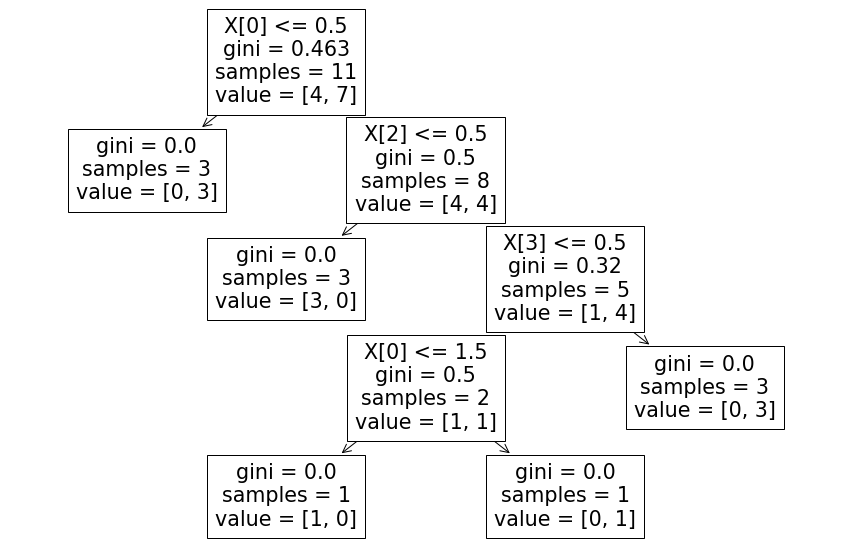

In [154]:
from matplotlib import pyplot as plt
from sklearn import tree
fig = plt.figure(figsize=(15,10))
tree.plot_tree(classifier);

## References

Code
  1. https://pbpython.com/categorical-encoding.html
  2. https://machinelearningmastery.com/implement-resampling-methods-scratch-python/
  3. https://medium.com/@penggongting/implementing-decision-tree-from-scratch-in-python-c732e7c69aea
  4. https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
  5. https://machinelearningmastery.com/implement-machine-learning-algorithm-performance-metrics-scratch-python/

Readings
  1. https://www.analyticsvidhya.com/blog/2020/10/all-about-decision-tree-from-scratch-with-python-implementation/
  2. https://medium.com/@penggongting/implementing-decision-tree-from-scratch-in-python-c732e7c69aea
  3. https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
